## Instruções para rodar esse notebook

Unzip o arquivo crime_data.zip na mesma pasta do notebook

- conda create -n chicago_crimes
- conda activate chicago_crimes
- conda config --env --add channels conda-forge
- conda config --env --set channel_priority strict
- conda install python=3.7 osmnx jupyter pandas geopandas seaborn folium

### Crimes em chicago 2017 - 2019

Neste notebook iremos realizar uma simples análise sobre os três últimos anos de crimes na cidade de Chicago e tentar olhar com mais detalhes um dos distritos policiais nos quais a cidade é dividida.
<br/>

#### Algumas perguntas que queremos responder

- Os crimes na cidade estão mudando ao longo dos anos?  
- Quais locais onde existem maior correncia de crimes e quais os tipos dos crimes?  
- Existe algum dia, local ou hora especificos em que o crime se concentra?  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox
from os import listdir
from os.path import isfile, join
import numpy as np
import folium                                
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
%matplotlib inline
plt.style.use('seaborn')

#### Importando os dados

In [2]:
path = './crime_data/Chicago'

chicago = [pd.read_csv(join(path, f)) for f in listdir(path) if isfile(join(path, f))]
chicago = pd.concat(chicago, axis=0, ignore_index=True)

In [3]:
chicago.head(4)

ID Case Number                    Date                 Block  IUCR  \
0  11080822    JA422909  09/07/2017 10:07:00 PM  058XX N ST LOUIS AVE  0930   
1  11075910    JA416934  09/02/2017 10:30:00 PM    069XX S KARLOV AVE  0281   
2  11106897    JA456000  10/02/2017 10:00:00 PM    115XX S HALSTED ST  051A   
3  12117868    JD311495  11/01/2017 12:00:00 AM    085XX S JUSTINE ST  1582   

                 Primary Type                    Description  \
0         MOTOR VEHICLE THEFT  THEFT / RECOVERY - AUTOMOBILE   
1     CRIMINAL SEXUAL ASSAULT                 NON-AGGRAVATED   
2                     ASSAULT           AGGRAVATED - HANDGUN   
3  OFFENSE INVOLVING CHILDREN              CHILD PORNOGRAPHY   

  Location Description  Arrest  Domestic  ...  Ward  Community Area  FBI Code  \
0               STREET   False     False  ...  39.0              13        07   
1            RESIDENCE   False     False  ...  13.0              65        02   
2           RESTAURANT   False     False  ...  34.0              53       04A   
3            RESIDENCE   False     False  ...  21.0              71        17   

   X Coordinate Y Coordinate  Year              Updated On   Latitude  \
0     1151986.0    1938811.0  2017  08/05/2020 03:51:40 PM  41.987972   
1     1150234.0    1858161.0  2017  08/05/2020 03:51:40 PM  41.766694   
2     1173050.0    1828446.0  2017  08/04/2020 03:48:19 PM  41.684678   
3     1167494.0    1848047.0  2017  08/03/2020 03:52:51 PM  41.738587   

   Longitude                       Location  
0 -87.716349  (41.987971693, -87.716349482)  
1 -87.724896   (41.766693549, -87.72489639)  
2 -87.642141  (41.684678113, -87.642141296)  
3 -87.661921  (41.738586877, -87.661920802)  

[4 rows x 22 columns]

- A cidade de Chicago é dividida em distritos policiais, e eles disponibilizam as geometrias desses distritos.

In [4]:
bounds = gpd.read_file(join(path,'utils/Boundaries - Police Districts (current).geojson'))
bounds['dist_num'] = bounds['dist_num'].astype(int).copy()
bounds.head(5)

dist_label  dist_num                                           geometry
0       17TH        17  MULTIPOLYGON (((-87.71067 41.99737, -87.71067 ...
1       20TH        20  MULTIPOLYGON (((-87.66029 41.99092, -87.66029 ...
2       31ST        31  MULTIPOLYGON (((-87.82818 41.98384, -87.82816 ...
3       31ST        31  MULTIPOLYGON (((-87.83365 41.97535, -87.83366 ...
4       19TH        19  MULTIPOLYGON (((-87.64492 41.96973, -87.64431 ...

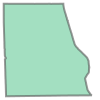

In [5]:
bounds['geometry'].values[0]

#### Olhando para os dados

In [6]:
chicago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796335 entries, 0 to 796334
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    796335 non-null  int64  
 1   Case Number           796335 non-null  object 
 2   Date                  796335 non-null  object 
 3   Block                 796335 non-null  object 
 4   IUCR                  796335 non-null  object 
 5   Primary Type          796335 non-null  object 
 6   Description           796335 non-null  object 
 7   Location Description  793055 non-null  object 
 8   Arrest                796335 non-null  bool   
 9   Domestic              796335 non-null  bool   
 10  Beat                  796335 non-null  int64  
 11  District              796334 non-null  float64
 12  Ward                  796315 non-null  float64
 13  Community Area        796335 non-null  int64  
 14  FBI Code              796335 non-null  object 
 15  

- Existem diversas colunas que podem ajudar a visualizar o que queremos, mas retiramos algumas que não colaboram com esse trabalho

In [7]:
chicago.drop(columns=['Case Number', 'IUCR', 'ID', 'FBI Code', 'Updated On', 
                   'X Coordinate', 'Y Coordinate', 'Beat', 'Ward'], inplace=True)

In [8]:
chicago.isna().sum()

Date                       0
Block                      0
Primary Type               0
Description                0
Location Description    3280
Arrest                     0
Domestic                   0
District                   1
Community Area             0
Year                       0
Latitude                9582
Longitude               9582
Location                9582
dtype: int64

In [9]:
(chicago['Latitude'].isna().value_counts().values[1] / chicago['Latitude'].isna().value_counts().values[0]) * 100

1.217917186207107

- O dataset é até bem comportado e mesmo com 9582 dados faltantes de Latitude e Longitude, isso só representa 1,2% do total de dados que temos, então podemos retirar todas as colunas em que Lat e Lon são nulos, pois esses são um dos nossos principais dados de analise

In [10]:
chicago.dropna(inplace=True)

- A informação de data e hora também é muito importante entao precisamos converter a coluna 'Date' em um formato mais facil de trabalhar

In [11]:
chicago['datetime'] = pd.to_datetime(chicago['Date']).copy()

In [12]:
chicago.index = pd.DatetimeIndex(chicago['datetime'])

In [13]:
chicago['District'] = chicago['District'].astype(int).copy()

- Vamos ver quais os tipos de crimes mais recorrentes nos ultimos tres anos?

Text(0, 0.5, 'Crime type')

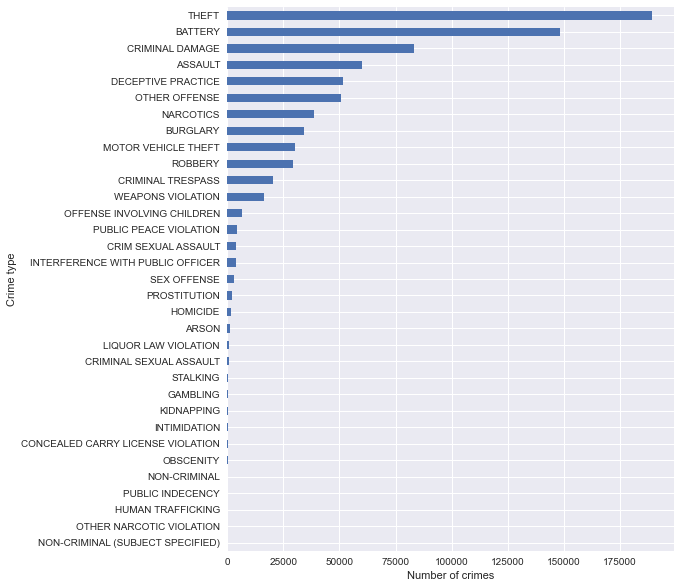

In [14]:
plt.figure(figsize=(8,10))
chicago['Primary Type'].value_counts().sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Number of crimes")
plt.ylabel("Crime type")

- Parece que roubo é o tipo de crime com maior incidencia... um pouco mais adiante iremos filtrar os tipos de crimes que nos interessam nessa analise!

Então, onde esses crimes normalmente acontecem?

Text(0, 0.5, 'Location')

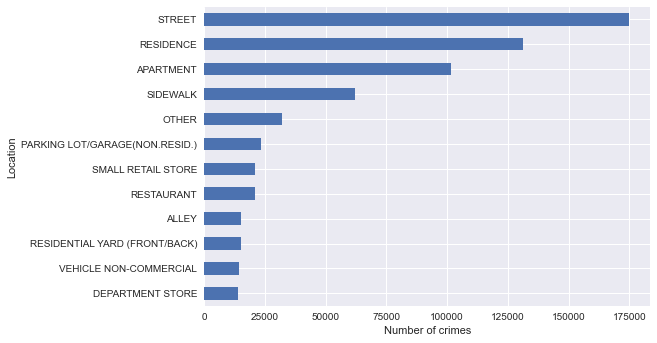

In [15]:
chicago['Location Description'].value_counts().head(12).sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Number of crimes")
plt.ylabel("Location")

- Parece que a maioria dos problemas se encontram na rua!

- Acredito que já possamos filtrar os tipos de crimes que são interessantes para nós.

In [16]:
chicago = chicago[
    (chicago['Primary Type'] == 'THEFT') | 
    (chicago['Primary Type'] == 'ASSAULT') | 
    (chicago['Primary Type'] == 'BURGLARY') | 
    (chicago['Primary Type'] == 'ROBBERY') | 
    (chicago['Primary Type'] == 'MOTOR VEHICLE THEFT') ]

Podemos agora tentar ter uma ideia do que está acontecendo ao longo de três anos!

Text(0.5, 0, 'Meses')

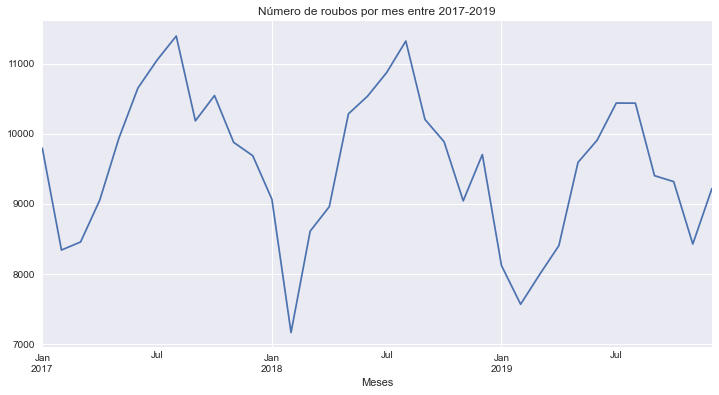

In [17]:
plt.figure(figsize=(12, 6))
chicago.resample('M').size().plot(legend=False)
plt.title('Número de roubos por mes entre 2017-2019')
plt.xlabel('Meses')

- Podemos ver que existe uma sazonalidade nos dados, sendo os meses de julho sempre mais complicados. Acredito que já seja um bom indicativo sobre como é possivel prever crimes na cidade.

- Mas também queremos ver se os crimes estão realmente diminuindo ou aumentando ao longe desses tres anos.

Text(0, 0.5, 'Média de crimes')

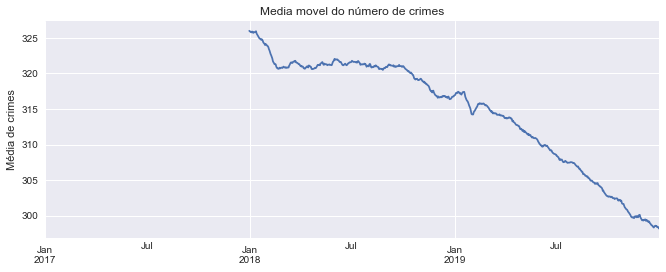

In [18]:
plt.figure(figsize=(11,4))
chicago.resample('D').size().rolling(365).mean().plot()
plt.title('Media movel do número de crimes')
plt.xlabel('')
plt.ylabel('Média de crimes')

- Fizemos a media dos 365 dias de 2017 e usamos como ponto de partida para o inicio de 2018, computando para cada dia adianta, a media dos ultimos 365 dias e podemos ver uma clara tendencia de queda!

Text(0.5, 1.0, 'Crimes por dia da semana')

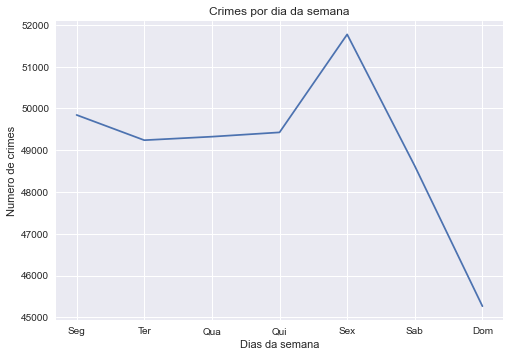

In [19]:
dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom']
chicago.groupby([chicago.index.dayofweek]).size().plot()
plt.ylabel('Numero de crimes')
plt.xlabel('Dias da semana')
plt.xticks(np.arange(7), dias)
plt.title('Crimes por dia da semana')

E que sexta realmente foi um dia mais complicado nos ultimos 3 anos.

- Podemos dividir o dia em quatro partes, sendo madrugada, entre 00-06, manha entre 06-12, tarde entre 12-18 e noite entre 18-24.

In [20]:
chicago['period'] = pd.cut(chicago.index.hour, bins=4, labels=('Madrugada','Manha', 'Tarde', 'Noite'))

Text(0.5, 1.0, 'Crimes por periodo')

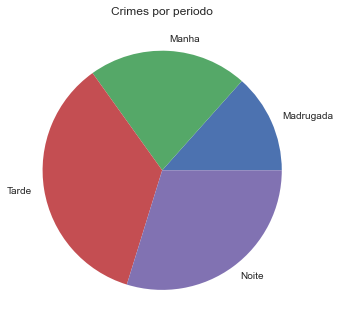

In [21]:
labels = ['Madrugada','Manha', 'Tarde', 'Noite']
chicago.groupby('period').size().plot(kind='pie')
plt.ylabel('')
plt.title("Crimes por periodo")

- Podemos ver que o periodo da tarde e noite sao responsaveis pela maior parcela dos crimes, o que combina muito com sexta-feira e com mais pessoas na rua no periodo da tarde e noite.

<AxesSubplot:xlabel='datetime'>

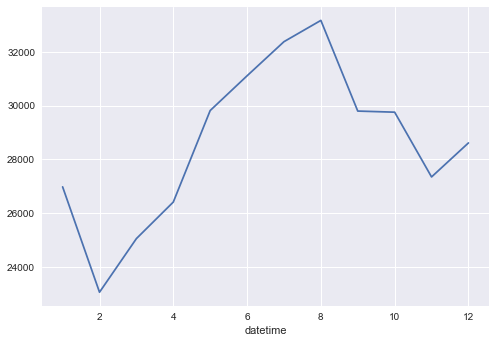

In [22]:
chicago.groupby([chicago.index.month]).size().plot()

- E que a quantidade de crimes aumenta nos periodos de férias e verão.

In [23]:
coord_df = chicago[['Latitude','Longitude']].apply(tuple, axis=1)
coord_df = coord_df[(coord_df.index.year == 2019) & (coord_df.index.month > 7)].copy() 

In [24]:
m = folium.Map([41.852124, -87.667686], zoom_start=10, width='100%', height='100%')
m.add_child(HeatMap(coord_df, radius=8))

In [25]:
m = folium.Map([41.852124, -87.667686], zoom_start=10, width='100%', height='100%')
m.add_child(FastMarkerCluster(coord_df, radius=8))

- Para ter uma ideia da distribuição dos crimes geograficamente, podemos plotar um mapa de calor ou utilizar markers clusterizados sobre o mapa, foram utilizados os ultimos 5 meses de 2019, devido o número de dados.

<AxesSubplot:ylabel='District'>

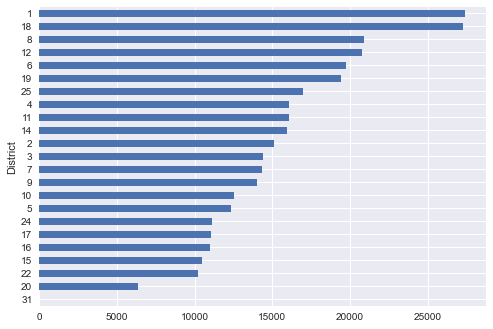

In [26]:
chicago.groupby('District').size().sort_values(ascending=True).plot(kind='barh')

- E podemos ver que os distritos  1 e 18 são os campeões em número de ocorrencias.

In [27]:
crimes_by_district = chicago['District'].value_counts()

In [28]:
bounds.set_index('dist_num', inplace=True)

In [29]:
bounds['Crimes sum'] = crimes_by_district
geo_bounds = gpd.GeoDataFrame(bounds, geometry=bounds['geometry'], crs='epsg:4326')

In [30]:
m = folium.Map([41.852124, -87.667686], zoom_start=10, width='100%', height='100%')
choropleth = folium.Choropleth(
    geo_data=bounds,
    data=bounds,
    key_on='feature.properties.dist_label',
    columns=['dist_label', 'Crimes sum' ],
    fill_color='Reds',
    legend_name='Numero de crimes',
    smooth_factor=0
)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(
        fields=['dist_label', 'Crimes sum'], 
        aliases=['Distrito: ','Total de crimes: '],)
)

m.add_child(choropleth)

m

- Mas quais ruas são as mais perigosas? Vamos analisar as areas mais perigosas da cidade, no caso o distrito policial que concentra o o maior numero de crimes, é o distrito 1.

In [31]:
chicago_graph = ox.graph_from_polygon(geo_bounds['geometry'].loc[1])

### E agora podemos ver a rede de ruas da area!

In [32]:
nodes, edges = ox.graph_to_gdfs(chicago_graph)

In [33]:
dist1 = geo_bounds[geo_bounds['dist_label'] == '1ST']

<AxesSubplot:>

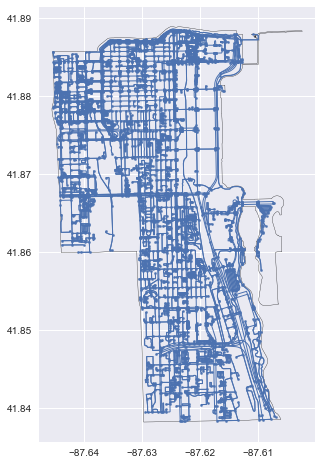

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot the footprint
dist1.plot(ax=ax, facecolor='none', edgecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=1)
nodes.plot(ax=ax, markersize=5)

- Queremos agora saber quantos crimes cada segmento de rua possui, com isso podemos ver onde o crime está concentrado! Vamos usar o ano de 2019 para analise.

In [35]:
dist1_crimes = chicago[(chicago['District'] == 1) & (chicago.index.year == 2019)]

In [36]:
dist1_gpd = gpd.GeoDataFrame(dist1_crimes,
                             crs='epsg:4326',
                             geometry=gpd.points_from_xy(
                                 dist1_crimes['Longitude'], 
                                 dist1_crimes['Latitude']))

In [37]:
dist1_gpd = dist1_gpd.to_crs(crs='epsg:26916')

In [38]:
proj_graph = ox.project_graph(chicago_graph, to_crs='epsg:26916')

In [39]:
nearest_edges = ox.get_nearest_edges(proj_graph, dist1_gpd['geometry'].x, 
                     dist1_gpd['geometry'].y,
                     dist=10,
                     method='kdtree'
                    )

In [40]:
nearest_edges = pd.DataFrame(nearest_edges, columns=['u', 'v', 'key'])

In [41]:
n_edges = nearest_edges.groupby(['u', 'v']).size().sort_values(ascending=False)

- Podemos agora ver o numero de crimes em cada segmento de rua! Qual será a concentração de crimes nos segmentos com mais ocorrencias?

- Vamos escolher por exemplo 20% do total de ruas que contem crimes, sendo essas ruas ordenadas pelo número de ocorrencias, e ver quanto elas guardam do total.

In [42]:
percent_ruas = int(len(n_edges) * 0.2)

In [43]:
print(str(percent_ruas)+' ruas de '+str(len(n_edges)) +
      ' possuem '+str(int((n_edges.head(percent_ruas).sum() / len(dist1_crimes)) * 100))+
      '% dos crimes')

190 ruas de 953 possuem 75% dos crimes


### Poucas ruas concentram a maior parte das ocorrencias, não é?

- E onde estão essas ruas?

In [44]:
n_edges.head(percent_ruas)

u           v         
4156112897  5836324694    560
4428028391  6131658789    319
27446709    6475978849    289
262072521   6475978845    184
28290265    740271858     179
                         ... 
4489793461  4226924811     11
261205210   3603750518     11
3213506207  253960127      11
33412599    7036553160     11
740260045   258021250      11
Length: 190, dtype: int64

In [45]:
edges['uv'] = edges[['u','v']].apply(tuple, axis=1)

In [46]:
hot_edges = edges[edges['uv'].isin(list(n_edges.head(percent_ruas).index))]

<AxesSubplot:>

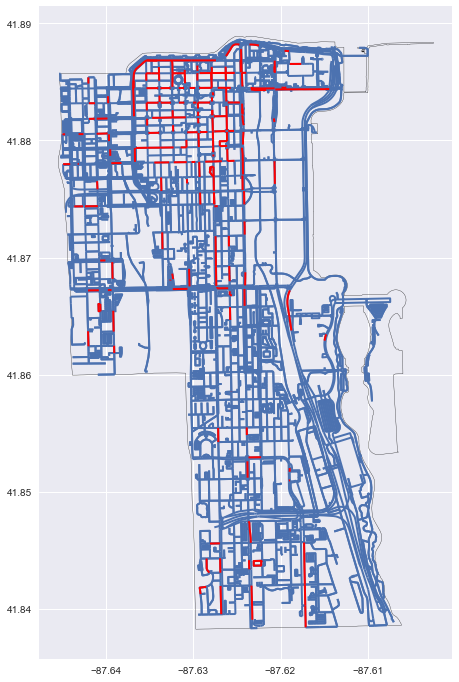

In [47]:
fig, ax = plt.subplots(figsize=(16,12))

# Plot the footprint
dist1.plot(ax=ax, facecolor='none', edgecolor='black')

# Plot street edges
edges.plot(ax=ax, linewidth=2)
hot_edges.plot(ax=ax, linewidth=2, color='red')

- As ruas em vermelho são as ruas com maior taxa de crimes no distrito e onde se concentra boa parte do problema!